In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
import time
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
#Importing the CSVs to Dataframe format
UsersDF = pd.read_csv('../raw_data/users_cleaned.csv')
AnimesDF = pd.read_csv('../raw_data/anime_cleaned.csv')
ScoresDF = pd.read_csv('../raw_data/animelists_cleaned.csv')

In [47]:
AnimesDF

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,cluster
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,0,0,0,0,1,0,0,0,0,32
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,0,0,0,0,0,0,0,0,0,44
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,0,0,0,0,0,0,0,0,0,47
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,0,0,0,0,0,0,0,0,0,1
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,0,0,0,0,0,0,0,0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,37405,Dokidoki Little Ooyasan,NaN,dokidokiりとる大家さん,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Other,0,Currently Airing,...,0,0,0,0,0,0,0,0,0,8
6664,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,我是江小白 小剧场,Wo Shi Jiang Xiao Bai: Xiao Ju Chang,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Original,1,Finished Airing,...,1,0,0,0,0,0,0,0,0,36
6665,37255,Genki Genki Non-tan: Obake Mura Meiro,NaN,げんきげんきノンタン おばけむらめいろ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Original,1,Finished Airing,...,0,0,0,0,0,0,0,0,0,10
6666,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Picture book,0,Currently Airing,...,0,0,0,0,0,0,0,0,0,36


In [3]:
# Preprocessing
AnimesDF = AnimesDF.dropna(subset=['genre'])
AnimesDF['genre'] = AnimesDF['genre'].str.split(', ')

In [4]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(AnimesDF['genre'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=AnimesDF.index)
AnimesDF = pd.concat([AnimesDF, genre_df], axis=1)

# Select and scale features
selected_columns = ['score', 'episodes', 'members', 'duration_min'] + list(mlb.classes_)
anime_df_selected = AnimesDF[selected_columns].dropna()
scaler = StandardScaler().set_output(transform = "pandas")
anime_df_scaled = scaler.fit_transform(anime_df_selected)

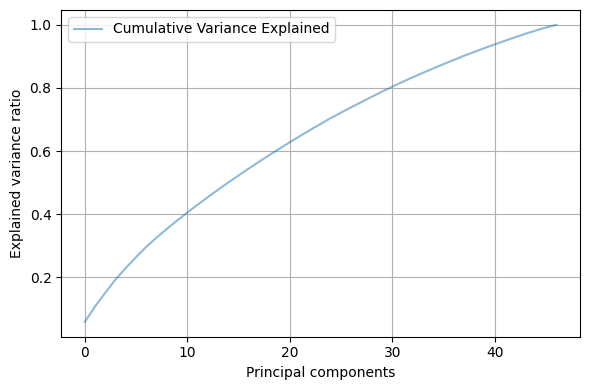

In [40]:
# Apply PCA
pca = PCA().set_output(transform = "pandas")
features_pca = pca.fit_transform(anime_df_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(range(len(explained_variance)), np.cumsum(explained_variance), alpha=0.5, label='Cumulative Variance Explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

# Use PCA to reduce dimensionality to 
pca = PCA(n_components=20)
features_pca = pca.fit_transform(anime_df_scaled)

In [44]:
# SCALING AND PRESERVING COLUMNS'NAMES
scaler = StandardScaler().set_output(transform = "pandas")
anime_df_scaled = scaler.fit_transform(anime_df_selected)
display(anime_df_scaled)

# PCA'ING AND PRESERVING COLUMNS'NAMES
threhsold_pca = 20
pca = PCA(n_components=threhsold_pca, whiten=True).set_output(transform="pandas") # find all the Principal Components PC (no y!)
pca.fit(anime_df_scaled)
features_pca = pca.transform(anime_df_scaled)
display(features_pca)
features_pca = pca.transform(anime_df_scaled)

,score,episodes,members,duration_min,Action,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.841724,-0.055832,2.248116,-0.175806,-0.666793,-0.5052,-0.07868,1.098131,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,2.597852,-0.109531,-0.123429,-0.064957,-0.038767
1,1.122227,0.286342,1.488368,-0.175806,-0.666793,-0.5052,-0.07868,1.098131,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
2,0.755415,0.897367,0.215043,-0.175806,-0.666793,-0.5052,-0.07868,1.098131,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
3,1.467462,0.579634,0.435561,-0.491233,-0.666793,-0.5052,-0.07868,1.098131,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
4,1.963737,0.261901,1.286369,-0.175806,-0.666793,-0.5052,-0.07868,1.098131,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,2.880767,-0.349124,-0.448555,0.060763,-0.666793,-0.5052,-0.07868,-0.910638,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
6664,-7.389971,-0.324683,-0.448298,-1.122085,-0.666793,-0.5052,-0.07868,-0.910638,-0.084279,-0.18607,...,-0.091225,2.487726,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
6665,-2.858763,-0.324683,-0.451599,0.257905,-0.666793,-0.5052,-0.07868,-0.910638,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767
6666,-2.459585,-0.349124,-0.451484,-1.043229,-0.666793,-0.5052,-0.07868,-0.910638,-0.084279,-0.18607,...,-0.091225,-0.401974,-0.196193,-0.23115,-0.241416,-0.384933,-0.109531,-0.123429,-0.064957,-0.038767


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19
0,-0.064092,1.642847,-0.170529,-0.710953,0.529755,-0.151465,0.272472,-0.220640,0.743920,-0.084949,-0.836322,-1.259261,0.923645,0.222383,0.020997,-0.063550,-0.134302,-0.204980,-0.300971,0.444229
1,-0.809166,1.037070,-0.479591,-1.795311,1.323181,0.195776,0.185371,1.062376,0.425813,0.177680,-0.724229,-0.646245,1.593993,2.700179,-1.161282,-0.682558,-0.909886,0.029448,0.776147,-0.986190
2,-1.068759,0.834483,-0.015447,-0.718786,-1.388827,0.117689,1.110561,-0.053928,0.113757,1.058413,0.155838,0.923657,-0.649436,1.687263,-1.398264,0.733976,-0.927297,1.547623,-0.073891,-0.758666
3,-0.271669,1.215329,0.193836,-0.730213,-1.975713,0.416575,0.854723,0.212409,-0.319980,-0.226212,0.038694,0.441890,0.606787,0.861138,-0.247734,-0.636612,-0.273457,0.362591,-0.205720,1.183973
4,0.049086,1.180165,-0.650921,-1.164518,0.001148,1.130081,0.609129,-0.216613,0.120660,-0.136271,-1.049674,-0.830002,1.107592,0.202021,0.567482,-0.199951,-0.184695,-0.297753,-0.141036,0.419265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,-0.240462,-0.268169,-0.278194,0.805042,-0.043675,0.414791,-0.417594,-1.830000,-0.946789,0.289713,0.696859,-2.344391,0.987060,0.453004,-0.780165,0.016204,-0.618334,0.521870,-1.673281,-0.631760
6664,-1.829640,-1.489225,-0.673953,0.974496,-0.788328,-0.458489,-0.857444,0.247456,0.084571,0.100456,-0.862146,1.004182,-0.603435,-1.168842,1.842013,-0.217341,0.144314,-0.423631,0.303892,0.348046
6665,-1.169637,-1.757394,0.429719,1.304811,-0.635446,-0.451544,0.279150,0.142189,-0.042498,0.652946,-0.719975,1.046107,-0.744514,-2.247484,-0.005417,0.363057,0.277234,-0.723026,1.544223,0.193843
6666,-1.077298,-1.458677,0.739643,1.101840,-0.159259,-0.673601,0.181129,0.577181,0.002908,-0.282077,-0.253176,0.426655,0.034892,-1.366084,1.291451,-0.453500,-0.330032,0.445296,0.235817,-0.750795


In [45]:
# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['k', 'Silhouette Score', 'Calinski Harabasz Score', 'Davies Bouldin Score'])

# Loop over the range of k values
for k in range(2, 50):  # we start from 2 because silhouette_score is not defined for a single cluster
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 'auto')
    clusters = kmeans.fit_predict(features_pca)

    silhouette = silhouette_score(features_pca, clusters)
    calinski_harabasz = calinski_harabasz_score(features_pca, clusters)
    davies_bouldin = davies_bouldin_score(features_pca, clusters)

    results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)

# Display the results
print(results)


/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)
/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)
/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  re

/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)
/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)
/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  re

/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)
/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)
/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  re

       k  Silhouette Score  Calinski Harabasz Score  Davies Bouldin Score
0    2.0          0.085331               240.506068              4.456268
1    3.0          0.081979               259.052194              3.693359
2    4.0          0.062335               261.036922              3.241752
3    5.0          0.065462               267.356862              2.985770
4    6.0          0.082827               261.624132              2.723928
5    7.0          0.098753               280.307171              2.383987
6    8.0          0.092124               293.605583              2.171246
7    9.0          0.106848               294.690569              2.151885
8   10.0          0.115269               318.752467              1.992775
9   11.0          0.148325               340.504347              1.813255
10  12.0          0.152650               338.782598              1.766074
11  13.0          0.155080               355.818917              1.701008
12  14.0          0.162993            

/var/folders/8b/mfpwpgc50qzd5q81s_p1v5_h0000gn/T/ipykernel_68473/3462345461.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, ignore_index=True)


In [46]:
# Add clusters to the DataFrame
AnimesDF['cluster'] = clusters
# Check the number of animes in each cluster
print(AnimesDF['cluster'].value_counts())

42    567
4     347
5     337
8     308
10    276
20    276
3     261
16    253
1     245
48    223
14    223
26    221
19    199
44    198
36    189
11    159
24    159
38    152
47    142
29    139
45    133
32    126
28    125
12    119
46    108
41    105
2     102
0     100
35     96
37     91
43     80
21     72
23     57
27     56
22     55
13     54
40     53
25     45
34     40
7      28
18     26
39     23
6      20
33     19
17     19
9      18
31     10
15      8
30      2
Name: cluster, dtype: int64


In [39]:
# Check the mean values of the features in each cluster
print(AnimesDF.groupby('cluster')[['episodes', 'score', 'members', 'duration_min']].mean())

            episodes     score        members  duration_min
cluster                                                    
0          34.266667  7.595333   69179.066667     48.333333
1          11.218868  6.911358   52841.600000     28.671824
2          16.822917  7.793125   66959.218750     43.385417
3           8.177866  7.222530   82656.778656     35.586957
4          22.882845  6.680837   21796.991632     27.067992
5          12.545024  6.598389   37517.056872     16.629542
6           2.000000  6.320000   13998.700000     20.100000
7           8.841549  6.523768   20446.383803     18.977113
8           9.931034  6.602644   43452.850575     36.193870
9           7.555556  7.020370   34297.407407     23.826852
10          9.871795  7.366282   52528.128205     47.205128
11          9.789189  6.008252   10059.670270     11.150420
12         10.018519  6.998148   50754.537037     22.296296
13          9.882979  7.175000  103309.436170     27.404255
14          1.678571  6.482857   20838.2

In [28]:
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of all genres
all_genres = list(set(itertools.chain.from_iterable(GenreDF)))

# Initialize a co-occurrence matrix of zeros
co_occurrence_matrix = pd.DataFrame(np.zeros((len(all_genres), len(all_genres))), index=all_genres, columns=all_genres)

# Iterate through each list of genres and increment co-occurrence matrix for each pair
for genres in GenreDF:
    for genre1, genre2 in itertools.combinations(genres, 2):
        co_occurrence_matrix.loc[genre1, genre2] += 1
        co_occurrence_matrix.loc[genre2, genre1] += 1

# Plot the co-occurrence matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(co_occurrence_matrix, cmap='YlGnBu')
plt.title('Genre Co-occurrence Heatmap')
plt.show()


NameError: name 'GenreDF' is not defined

In [ ]:
# Apply Elbow method
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
AnimesDF